### Import Libraries

# New Section

In [1]:

import numpy as np
import pandas as pd
import glob
import time
import pandas as pd
# from xml.dom import minidom


import os
import matplotlib.pyplot as plt
import keras

import cv2

In [2]:
df=pd.read_csv('../dataset/XSS_dataset_11.csv', encoding='utf-8-sig')

In [3]:
df.head()

,No,Sentence,Label
0,0,<img onmouseleave=alert(1)>test</img>,1
1,1,</div> </td><td class=navbox-image rowspan=6 s...,0
2,2,<dl><dt><i>The <a href=/wiki/AI_effect title=A...,0
3,3,<object onmouseout=alert(1)>test</object>,1
4,4,<body class=wy-body-for-nav>,0


In [4]:
df=df[df.columns[-2:]]  # Only get sentence and labels

In [5]:
df.head()

,Sentence,Label
0,<img onmouseleave=alert(1)>test</img>,1
1,</div> </td><td class=navbox-image rowspan=6 s...,0
2,<dl><dt><i>The <a href=/wiki/AI_effect title=A...,0
3,<object onmouseout=alert(1)>test</object>,1
4,<body class=wy-body-for-nav>,0


In [6]:
# Get Sentences data from data frame
sentences=df['Sentence'].values
sentences[1]

'</div> </td><td class=navbox-image rowspan=6 style=width:1px;padding:0px 0px 0px 2px>'

In [7]:
print(len(sentences))

12000


In [8]:
# Convert to ASCII

def convert_to_ascii(sentence):
    sentence_ascii=[]

    for i in sentence:
        
        
        """Some characters have values very big e.d 8221 adn some are chinese letters
        I am removing letters having values greater than 8222 and for rest greater 
        than 128 and smaller than 8222 assigning them values so they can easily be normalized"""
       
        if(ord(i)<8222):      # ” has ASCII of 8221
            
            if(ord(i)==8217): # ’  :  8217
                sentence_ascii.append(134)
            
            
            if(ord(i)==8221): # ”  :  8221
                sentence_ascii.append(129)
                
            if(ord(i)==8220): # “  :  8220
                sentence_ascii.append(130)
                
                
            if(ord(i)==8216): # ‘  :  8216
                sentence_ascii.append(131)
                
            if(ord(i)==8217): # ’  :  8217
                sentence_ascii.append(132)
            
            if(ord(i)==8211): # –  :  8211
                sentence_ascii.append(133)
                
                
            """
            If values less than 128 store them else discard them
            """
            if (ord(i)<=128):
                    sentence_ascii.append(ord(i))
    
            else:
                    pass
            

    zer=np.zeros((10000))

    for i in range(len(sentence_ascii)):
        zer[i]=sentence_ascii[i]

    zer.shape=(100, 100)


#     plt.plot(image)
#     plt.show()
    return zer


In [9]:


# send each sentence to be converted to ASCII


arr=np.zeros((len(sentences),100,100))

for i in range(len(sentences)):
    
    image=convert_to_ascii(sentences[i])

    x=np.asarray(image,dtype='float')
    image =  cv2.resize(x, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
    image/=128

    
#     if i==1:
#         plt.plot(image)
#         plt.show()    
    arr[i]=image



In [10]:
print("Input data shape : ", arr.shape)

Input data shape :  (12000, 100, 100)


In [11]:
# Reshape data for input to CNN
data = arr.reshape(arr.shape[0], 100, 100)

In [12]:
data.shape

(12000, 100, 100)

In [13]:
y=df['Label'].values

In [14]:
# Split into train/test data
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(data,y, test_size=0.2, random_state=42)

In [15]:
# import libraries for Making Model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D,Flatten,Dropout,MaxPool2D, BatchNormalization

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Attention, GlobalAveragePooling1D, AveragePooling1D, Softmax

inputs = Input(shape=(100, 100))

# Bi-LSTM layer
bi_lstm = Bidirectional(LSTM(128, return_sequences=True))(inputs)

# Attention layer
attention = Attention()([bi_lstm, bi_lstm])

# Global Average Pooling layer
gap = GlobalAveragePooling1D()(attention)

# Average Pooling layer
average_pooling = AveragePooling1D(pool_size=2)(tf.expand_dims(gap, axis=-1))
average_pooling = tf.squeeze(average_pooling, axis=-1)  # Remove the last dimension

# Dense layer with Sigmoid activation for binary classification
outputs = Dense(1, activation='sigmoid')(average_pooling)  # Single unit for binary classification

# Build the model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)


In [17]:

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100)]   0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 100, 256)     234496      ['input_1[0][0]']                
                                                                                                  
 attention (Attention)          (None, 100, 256)     0           ['bidirectional[0][0]',          
                                                                  'bidirectional[0][0]']          
                                                                                                  
 global_average_pooling1d (Glob  (None, 256)         0           ['attention[0][0]']          

In [18]:
# Stop when validation accuracy > 97

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.97):
            print(" \n Reached 97% + validation accuracy")
            self.model.stop_training=True
callbacks = myCallback()

In [19]:
batch_size = 128
num_epoch = 20
#model training
model_log = model.fit(trainX, trainY,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data=( testX,  testY)
#                        callbacks=[callbacks]
                     )

Epoch 1/20
75/75 [==============================] - 8s 56ms/step - loss: 0.6208 - accuracy: 0.6709 - val_loss: 0.5822 - val_accuracy: 0.7300
Epoch 2/20
75/75 [==============================] - 3s 41ms/step - loss: 0.5900 - accuracy: 0.7231 - val_loss: 0.5835 - val_accuracy: 0.7275
Epoch 3/20
75/75 [==============================] - 3s 40ms/step - loss: 0.5864 - accuracy: 0.7268 - val_loss: 0.5801 - val_accuracy: 0.7312
Epoch 4/20
75/75 [==============================] - 3s 40ms/step - loss: 0.5777 - accuracy: 0.7319 - val_loss: 0.5038 - val_accuracy: 0.7754
Epoch 5/20
75/75 [==============================] - 3s 41ms/step - loss: 0.3271 - accuracy: 0.8728 - val_loss: 0.2695 - val_accuracy: 0.9025
Epoch 6/20
75/75 [==============================] - 3s 40ms/step - loss: 0.2383 - accuracy: 0.9155 - val_loss: 0.2054 - val_accuracy: 0.9308
Epoch 7/20
75/75 [==============================] - 3s 41ms/step - loss: 0.2039 - accuracy: 0.9301 - val_loss: 0.1803 - val_accuracy: 0.9371
Epoch 8/20
75

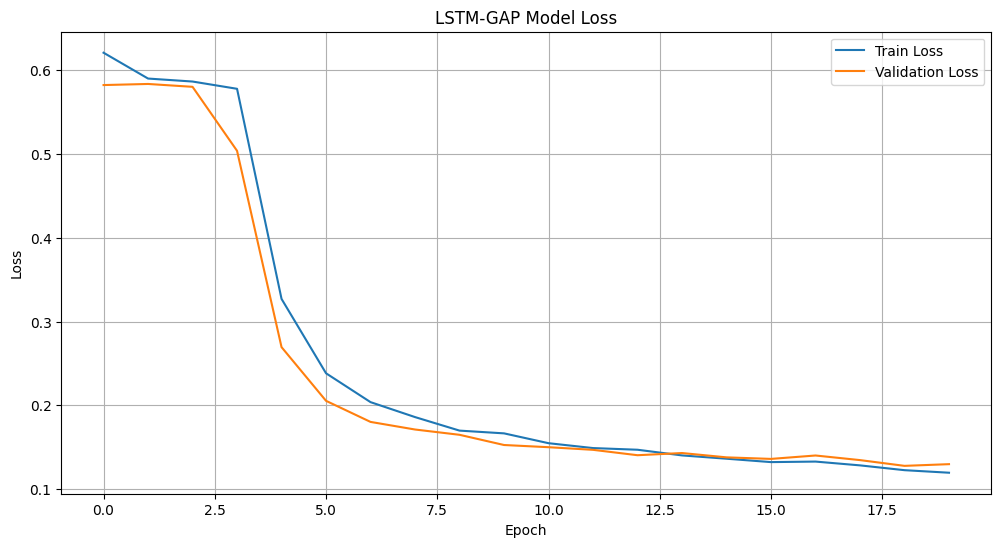

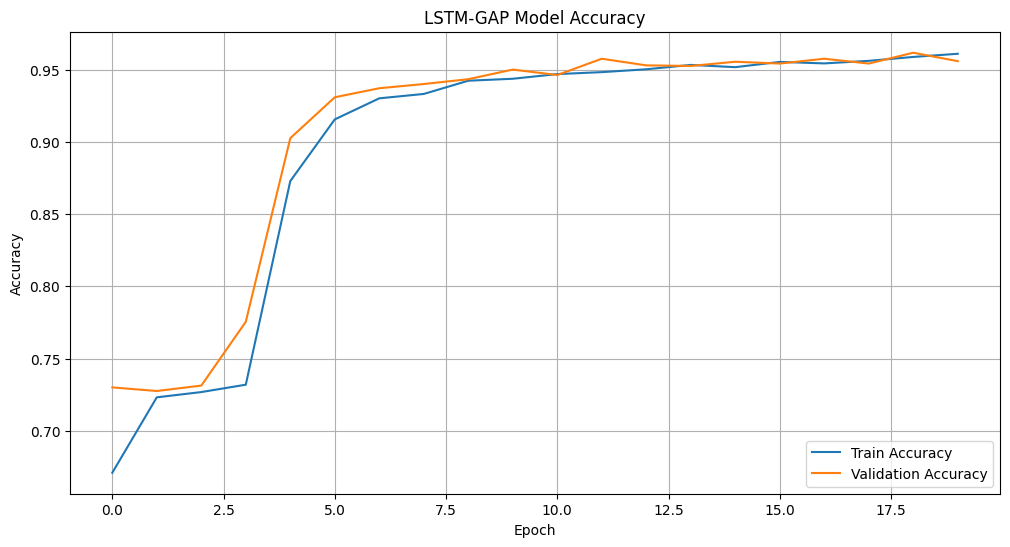

In [20]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 6))
plt.plot(model_log.history['loss'], label='Train Loss')
plt.plot(model_log.history['val_loss'], label='Validation Loss')
plt.title('LSTM-GAP Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Vẽ biểu đồ Accuracy
plt.figure(figsize=(12, 6))
plt.plot(model_log.history['accuracy'], label='Train Accuracy')
plt.plot(model_log.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM-GAP Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [21]:
# model.save("../web/models/BiLSTMxGAP.keras")
#loaded_model = keras.models.load_model("../web/models/BiLSTMxGAP.keras")
#assert np.allclose(model.predict(testX), loaded_model.predict(testX))

In [22]:
# predict for test set
pred=model.predict(testX)


75/75 [==============================] - 1s 12ms/step


In [23]:
# Threshold values predicted

for i in range(len(pred)):
    if pred[i]>0.5:
        pred[i]=1
    elif pred[i]<=0.5:
        pred[i]=0



In [24]:
# Count True predicted and wrong predicted

true=0
false=0

for i in range(len(pred)):
    if pred[i] == testY[i]:
        true+=1
    else:
        false+=1
        
print("correct predicted :: ", true)
print("false prediction :: ", false)

correct predicted ::  2294
false prediction ::  106


In [25]:
# Number of attack and benign data in test set

attack=0
benign=0
for i in range(len(testY)):
    if testY[i]==1:
        attack+=1
    else:
        benign+=1

print("Attack data in test set :: ", attack)
print(" Benign data in test set :: ", benign)

Attack data in test set ::  1193
 Benign data in test set ::  1207


### Confusion Matrix

In [26]:
# Takes True positive, true negative, false positive and false negative as input
# Returns Accuracy

def accuracy_function(tp,tn,fp,fn):
    
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    
    return accuracy

In [27]:
# Takes True Positive and false positive
# Returns Precision

def precision_function(tp,fp):
    
    precision = tp / (tp+fp)
    
    return precision

In [28]:
#Takes True Positive and false negative
# Returns Recall

def recall_function(tp,fn):

    recall=tp / (tp+fn)

    return recall

In [29]:
def f1_function(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1


In [30]:
#Takes true values and predicted
# Returns Accuracy, precision and recall


def confusion_matrix(truth,predicted):
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    
    for true,pred in zip(truth,predicted):
        if true == 1:
            if pred == true:
                true_positive += 1
            elif pred != true:
                false_negative += 1

        elif true == 0:
            if pred == true:
                true_negative += 1
            elif pred != true:
                false_positive += 1
    
    accuracy=accuracy_function(true_positive, true_negative, false_positive, false_negative)
    precision=precision_function(true_positive, false_positive)
    recall=recall_function(true_positive, false_negative)
    f1 = f1_function(true_positive,false_positive,false_negative)
    
    print(f"True Positive: {true_positive}")
    print(f"True Negative: {true_negative}")
    print(f"False Positive: {false_positive}")
    print(f"False Negative: {false_negative}")
    return (accuracy,
            precision,
            recall,
            f1)

In [31]:
accuracy, precision, recall, f1=confusion_matrix(testY,pred)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1-score: {3} ".format(accuracy, precision, recall, f1))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Giả định testY là nhãn thực và pred là nhãn dự đoán
accuracy = accuracy_score(testY, pred)
precision = precision_score(testY, pred)
recall = recall_score(testY, pred)
f1 = f1_score(testY, pred)

print("Accuracy: {0:.4f} \nPrecision: {1:.4f} \nRecall: {2:.4f} \nF1-score: {3:.4f}".format(accuracy, precision, recall, f1))

True Positive: 1153
True Negative: 1141
False Positive: 66
False Negative: 40
 Accuracy : 0.9558333333333333 
 Precision : 0.9458572600492207 
 Recall : 0.9664710813076278 
 F1-score: 0.9560530679933665 
Accuracy: 0.9558 
Precision: 0.9459 
Recall: 0.9665 
F1-score: 0.9561


In [32]:
# from openpyxl import Workbook, load_workbook
# from openpyxl.styles import PatternFill, Alignment

# models = {
#     "BiLSTM":2,
#     "LSTM-GAP":3,
#     "CNN":4,
#     "CNN-LSTM":5,
#     "TextCNN":6
# }

# file_name = "model_performance.xlsx"
# try:
#     wb = load_workbook(file_name)
# except FileNotFoundError:
#     # Nếu file không tồn tại, tạo một workbook mới
#     wb = Workbook()
#     sheet = wb.active
#     # Đặt màu nền cho dòng header
#     header_fill = PatternFill(start_color="92D050", end_color="92D050", fill_type="solid")

#     # Đặt tiêu đề cho các hàng và cột
#     sheet.cell(row=1, column=1).value = "Metric"
#     sheet.cell(row=1, column=1).fill = header_fill
#     metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "Correct Predict", "False Predict"]
#     for row, metric in enumerate(metrics, start=2):
#         cell = sheet.cell(row=row, column=1)
#         cell.value = metric
    
#     for col, model_name in enumerate(models, start=2):
#         cell = sheet.cell(row=1, column=col)
#         cell.value = model_name
#         cell.alignment = Alignment(horizontal="center", vertical="center")
#         cell.fill = header_fill

#     # Lưu file Excel mới
#     wb.save(file_name)
#     wb = load_workbook(file_name)

# sheet = wb.active
# sheet.column_dimensions['A'].width = 15
# model_name = "LSTM-GAP"
# col = models[model_name]
# # Ghi dữ liệu của từng mô hình vào cột tương ứng

# sheet.cell(row=2, column=col).value = f"{accuracy*100:.2f}%"
# sheet.cell(row=2, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=3, column=col).value = f"{precision*100:.2f}%"
# sheet.cell(row=3, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=4, column=col).value = f"{recall*100:.2f}%"
# sheet.cell(row=4, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=5, column=col).value = f"{f1*100:.2f}%"
# sheet.cell(row=5, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=6, column=col).value = true
# sheet.cell(row=6, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=7, column=col).value = false
# sheet.cell(row=7, column=col).alignment = Alignment(horizontal="center", vertical="center")

# # Lưu file Excel sau khi thêm dữ liệu
# wb.save(file_name)
